In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import gym
from collections import deque
import random
import itertools
from torch import nn
from torch.nn import functional
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import pickle

def save_rewards_data(rewards_data, filename='rewards_data.pkl'):
    """Save the rewards data to a pickle file."""
    with open(filename, 'wb') as file:
        pickle.dump(rewards_data, file)
    print(f'Rewards data saved to {filename}')


def load_rewards_data(filename='rewards_data.pkl'):
    """Load the rewards data from a pickle file."""
    try:
        with open(filename, 'rb') as file:
            rewards_data = pickle.load(file)
        print(f'Rewards data loaded from {filename}')
        return rewards_data
    except FileNotFoundError:
        print(f'Error: The file {filename} does not exist. Please check the file path and try again.')
        return None
    except Exception as e:
        print(f'An error occurred while loading the data: {e}')
        return None

class Fourier_Basis:
  def __init__(self, order, k):
    #self.env = env
    self.order = [order]*k
    self.coefficients = np.array([])

  def get_coefficients(self):
    prods = [range(0, i+1) for i in self.order]
    #print(prods)
    coeffs = [v for v in itertools.product(*prods)]
    self.coefficients = np.array(coeffs)
    return self.coefficients
  
  def value(self, state):
    self.get_coefficients()
    return np.cos(np.pi*np.dot(self.coefficients, state))

cpu


In [7]:
class Model(nn.Module):
    def __init__(self, input_features, output_values):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features=input_features, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=output_values)

    def forward(self, x):
        x = functional.selu(self.fc1(x))
        x = functional.selu(self.fc2(x))
        x = self.fc3(x)
        return x

class DDQN:
    def __init__(self, env, order, discretizer, use_cuda=True, learning_rate=1e-5, gamma=0.7, memory_len=10000, start_epsilon=1):
        self.device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
        self.env = env
        self.discretizer = discretizer
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.u_state = env.observation_space.high
        self.l_state = env.observation_space.low
        self.d_state = self.u_state - self.l_state
        self.n_features = len(env.observation_space.high)

        self.epsilon = start_epsilon
        self.min_epsilon = 0.0001
        self.epsilon_decay = 0.9 / 2.5e3
        self.memory_len = memory_len
        self.memory = deque(maxlen=self.memory_len)
        self.criterion = nn.MSELoss()

        input_features = (order + 1)**env.observation_space.shape[0]
        output_values = env.action_space.n
        self.policy_net = Model(input_features, output_values).to(self.device)
        self.target_net = Model(input_features, output_values).to(self.device)

        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

    def get_states_tensor(self, sample, states_idx):
        sample_len = len(sample)
        states_tensor = torch.empty((sample_len, self.n_features), dtype=torch.float32, requires_grad=False)

        features_range = range(self.n_features)
        for i in range(sample_len):
            for j in features_range:
                states_tensor[i, j] = sample[i][states_idx][j].item()

        return states_tensor

    def normalize_state(self, state):
        if type(state) == tuple:
            state = state[0]
        state[0] /= 1.8
        state[1] /= 0.14
        

    def state_reward(self, state, env_reward):
        return env_reward - (abs(state[0]) + abs(state[1])) / 2.5

    def get_action(self, state, e=0.001):
        if random.random() < e:
            return random.randrange(0, self.env.action_space.n)
        else:
            encoded_state = (state - self.l_state) / self.d_state
            state_cos = self.discretizer.value(encoded_state)
            encoded_state = torch.tensor(state_cos, dtype=torch.float32, device=self.device)
            return self.policy_net(encoded_state).argmax().item()

    def fit(self, model, inputs, labels):
        inputs = inputs.to(self.device)
        labels = labels.to(self.device)
        train_ds = TensorDataset(inputs, labels)
        train_dl = DataLoader(train_ds, batch_size=5)

        optimizer = torch.optim.Adam(params=model.parameters(), lr=self.learning_rate)
        model.train()
        total_loss = 0.0

        for x, y in train_dl:
            out = model(x)
            loss = self.criterion(out, y)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        return total_loss / len(train_dl)

    def optimize_model(self, train_batch_size=100):
        if len(self.memory) < train_batch_size:
            return
        train_sample = random.sample(self.memory, train_batch_size)

        state = torch.tensor([s[0] for s in train_sample], dtype=torch.float32, device=device)
        next_state = torch.tensor([s[3] for s in train_sample], dtype=torch.float32, device=device)

        q_estimates = self.policy_net(state).detach()
        next_state_q_estimates = self.target_net(next_state).detach()
        next_actions = self.policy_net(next_state).argmax(dim=1)

        for i in range(len(train_sample)):
            next_action = next_actions[i].item()
            q_estimates[i][train_sample[i][1]] = (train_sample[i][2] +
                                                  self.gamma * next_state_q_estimates[i][next_action].item())

        self.fit(self.policy_net, state, q_estimates)

    def train_one_episode(self):
        current_state = self.env.reset()
        #self.normalize_state(current_state)
        done = False
        score = 0
        reward = 0
        step = 0
        while not done and step < 200:
            if type(current_state) == tuple:
                current_state = current_state[0]
            action = self.get_action(current_state, self.epsilon)
            next_state, env_reward, done, info,  _ = self.env.step(action)
            #self.normalize_state(next_state)
            encoded_current_state = self.discretizer.value((current_state - self.l_state) / self.d_state)
            encoded_next_state = self.discretizer.value((next_state - self.l_state) / self.d_state)
            self.memory.append((encoded_current_state, action, env_reward, encoded_next_state))
            current_state = next_state
            score += env_reward
            reward += self.state_reward(next_state, env_reward)

            self.optimize_model(100)
            step += 1

            self.epsilon = max(self.min_epsilon, self.epsilon - self.epsilon_decay)

        return score, reward

    def test(self):
        state = self.env.reset()
        #self.normalize_state(state)
        done = False
        score = 0
        reward = 0
        step = 0
        while not done and step < 200:
            if type(state) == tuple:
                state = state[0]
            action = self.get_action(state, 0)  # Using 0 to bypass random action selection
            state, env_reward, done, info,  _ = self.env.step(action)
            #self.normalize_state(state)
            score += env_reward
            reward += self.state_reward(state, env_reward)
            step += 1

        return score, reward

In [8]:
env = gym.make('MountainCar-v0')

order = 10
k = env.observation_space.shape[0]
FB = Fourier_Basis(order, k)

In [9]:
def main(used_alpha, used_epsilon, env, order, discretizer, target_update_delay, test_delay, memory_len=10000, num_runs=1, num_episode=1000, save_file=""):


    # Initialize storage for reward data
    rewards_data = {epsilon: {alpha: [] for alpha in used_alpha} for epsilon in used_epsilon}

    for epsilon in used_epsilon:
        for alpha in used_alpha:
            print(f"Training with epsilon: {epsilon}, alpha: {alpha}")
            run_rewards = []  # Collect rewards for each run for the current config

            for run in range(num_runs):
                
                # avoid decay
                current_epsilon = epsilon

                print(f"Run {run + 1}/{num_runs}")
                
                # renew the wrapper class
                ddqn = DDQN(
                    env=env, 
                    order = order,
                    discretizer=discretizer, 
                    use_cuda=True, 
                    learning_rate=alpha, 
                    gamma=0.99,
                    memory_len=memory_len, 
                    start_epsilon=current_epsilon
                )

                best_test_reward = 0

                episode_rewards = []  # Collect rewards for each episode in the current run
                for i in range(num_episode):
                    score, reward = ddqn.train_one_episode()

                    print(f'Episode {i + 1}: score: {score} - reward: {reward}')

                    if i % target_update_delay == 0:
                        ddqn.target_net.load_state_dict(ddqn.policy_net.state_dict())
                        ddqn.target_net.eval()

                    if (i + 1) % test_delay == 0:
                        test_score, test_reward = ddqn.test()
                        print(f'Test Episode {i + 1}: test score: {test_score} - test reward: {test_reward}')
                        if test_reward > best_test_reward:
                            print('New best test reward. Saving model')
                            best_test_reward = test_reward
                            # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                    # Add the rewards
                    episode_rewards.append(score)

                if num_episode % test_delay != 0:
                    test_score, test_reward = ddqn.test()
                    print(f'Test Episode {num_episode}: test score: {test_score} - test reward: {test_reward}')
                    if test_reward > best_test_reward:
                        print('New best test reward. Saving model')
                        best_test_reward = test_reward
                        # torch.save(ddqn.policy_net.state_dict(), f'policy_net_{run}.pth')

                # save the run rewards
                run_rewards.append(episode_rewards)

                print(f'best test reward: {best_test_reward}')

            # Store the rewards for the current epsilon and alpha configuration
            rewards_data[epsilon][alpha] = run_rewards

    if not(save_file == ""):
        save_rewards_data(rewards_data, save_file)

    return rewards_data

In [13]:
rewards_data = main(
    used_alpha=[1e-4, 5e-4], 
    used_epsilon=[0.01],  # start epsilon
    env=env, 
    order = order,
    discretizer=FB,
    target_update_delay=2, 
    test_delay=10,
    memory_len=10000, 
    num_runs=3, 
    num_episode=500, 
    save_file="DDQN_Fourier_MC.pkl"
)

Training with epsilon: 0.01, alpha: 0.0001
Run 1/3
Episode 1: score: -200.0 - reward: -242.95640695095068
Episode 2: score: -200.0 - reward: -241.48932750225063
Episode 3: score: -200.0 - reward: -240.56390947103498
Episode 4: score: -200.0 - reward: -240.7297628641129
Episode 5: score: -200.0 - reward: -239.74626287221903
Episode 6: score: -200.0 - reward: -241.12291425466537
Episode 7: score: -200.0 - reward: -238.8877667665482
Episode 8: score: -200.0 - reward: -241.51360363960282
Episode 9: score: -200.0 - reward: -241.03542219400396
Episode 10: score: -200.0 - reward: -239.75424569845197
Test Episode 10: test score: -200.0 - test reward: -241.25664852857605
Episode 11: score: -200.0 - reward: -240.04299480319028
Episode 12: score: -200.0 - reward: -242.12875950336465
Episode 13: score: -200.0 - reward: -241.6636517405511
Episode 14: score: -200.0 - reward: -240.95845555663115
Episode 15: score: -200.0 - reward: -242.57470248043546
Episode 16: score: -200.0 - reward: -241.887670502

In [11]:
import matplotlib.pyplot as plt

def plot_rewards(rewards_data, algorithm_name="Q learning"):
    """Plot the average performance and IQR of the policy."""
    plt.figure(figsize=(14, 7))

    for epsilon, alphas in rewards_data.items():
        for alpha, data in alphas.items():
            # Calculate average and IQR across runs for each episode
            data = np.array(data)  # Convert to numpy array for easier slicing
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'ε={epsilon}, α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

    plt.title(f'Average Performance and IQR by Epsilon and Alpha ({algorithm_name})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()

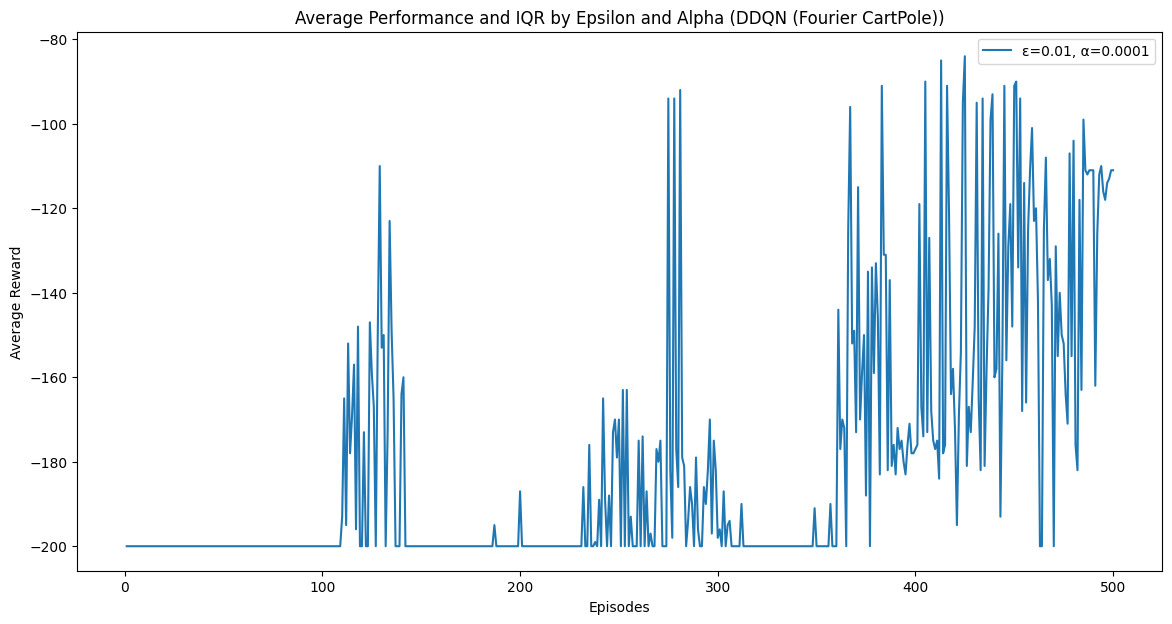

In [12]:
plot_rewards(rewards_data, algorithm_name="DDQN (Fourier MountainCar)")